In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
import tensorflow as tf
# import pydicom
from IPython.display import update_display
PATH = "/mnt/d/Datasets/miniMIAS/"
imgPATH = PATH + "all-mias/"
roi_path = PATH + "ROI/"
# malignant_roi_path = PATH + "ROI/malignant/"
# fullimg_benign_path = PATH + "fullimg/benign/"
# fullimg_malignant_path = PATH + "fullimg/malignant/"
image_size=300
output_size=300
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(1,1))

2023-02-20 21:00:54.092526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 21:00:55.428601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-20 21:00:55.428714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [2]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.5),fill_mode='reflect'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='reflect'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='reflect')
  ])

2023-02-20 21:00:56.615110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 21:00:56.692909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 21:00:56.692957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 21:00:56.693819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [3]:
def read_pgm(filename, byteorder='>'):                     # '>' indicates big-endian
  """Return image data from a raw PGM file as a np array.

  Format specification: http://netpbm.sourceforge.net/doc/pgm.html

  """

  with open(filename, 'rb') as f:
    buffer = f.read()
  try:
    header, width, height, maxval = re.search(  
    b"(^P5\s(?:\s*#.*[\r\n])*"                             # A pgm image's magic number is the two characters "P5"
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A width, formatted as ASCII characters in decimal
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A height, again in ASCII decimal
    b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()       # The maximum gray value (Maxval), again in ASCII decimal. 
                                                           # Must be less than 65536, and more than zero.
  except AttributeError:
    raise ValueError("Not a raw PGM file: '%s'" % filename)
    
  return np.frombuffer(buffer,
               dtype='u1' if int(maxval) < 256 else byteorder+'u2',
               count=int(width)*int(height),
               offset=len(header)
              ).reshape((int(height),int(width)))
              
def list_find(list, input):
    for i,x in enumerate(list):
        if x[3:6] == input:
            list_index = i
            return int(list_index)

def ROI(img_dir,x,y,r,save_path,file_name,calc,augment=0):   
  image = read_pgm(img_dir)
  if r < 50: r=50
  if 1024-y-r<0:r=1024-y
  if 1024-y+r>1024:r = y
  if x-r<0:r=x
  if x+r>1024:r = 1024-x
  # if calc:
    # image
  # else:
    # image = image[1024-int(y+r):1024-int(y-r),int(x-r):int(x+r)]
  if calc:
    image = image[int(y-r):int(y+r),int(x-r):int(x+r)]
  else:
    image = image[1024-int(y+r):1024-int(y-r),int(x-r):int(x+r)]
  ret,thresh = cv2.threshold(image,1,255,0)
  contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  if contours:
    cnt = contours[-1]
    x,y,w,h = cv2.boundingRect(cnt)
    # img = cv2.drawContours(image,[cnt],0,(255,255,255),2)
    # if w>10 and h>10:
    image = image[y:y+h,x:x+w]
  # image = cv2.medianBlur(image,3)
  image = clahe.apply(image)
  image =  cv2.resize(image,(output_size,output_size))
  directory = str(save_path)
  if not os.path.exists(directory):
      os.makedirs(directory)
  cv2.imwrite(save_path+file_name+'_1.png',image)
  image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
  for i in range(augment):
    image_aug = data_augmentation(image)
    # image_aug = cv2.cvtColor(image_aug,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(save_path+file_name+'_'+str(i+2)+'.png',image_aug.numpy())

def ROI_print(img_dir,x,y,r,clahe):   
  image = read_pgm(img_dir)
  image = image[1024-int(y+r):1024-int(y-r),int(x-r):int(x+r)]
  image = cv2.medianBlur(image,3)
  clahe = cv2.createCLAHE(clipLimit=clahe, tileGridSize=(8,8))
  image = clahe.apply(image)
  image =  cv2.resize(image,(output_size,output_size))
  # cv2.imwrite(save_path+file_name+'.png',image)
  return image

def ROI_box(img_dir,x,y,r):   
  image = read_pgm(img_dir)
  # image = image[int(y-r/2):int(y+r/2),int(x-r/2):int(x+r/2)]
  image = cv2.rectangle(image,(int(x-r),int(y-2*r)),(int(x+r),int(y)),(255,255,255),3)
  # image = cv2.medianBlur(image,3)
  # image = clahe.apply(image)
  # image =  cv2.resize(image,(output_size,output_size))
  # cv2.imwrite(save_path+file_name+'.png',image)
  return image

In [4]:
f = open('/mnt/c/Users/user/Desktop/mias-dataset/mias-dataset/MIASinfo.txt', 'r')
line = f.readlines()

In [5]:
benign_calc = []
benign_mass = []
malignant_calc = []
malignant_mass = []
for dirName, subdirList, fileList in os.walk(imgPATH):
  if dirName == imgPATH:
    for i,fname in enumerate(fileList):
        if fname.endswith(".pgm"):
          image_no = fname[3:6]
          indice = list_find(line,image_no)
          if len(line[indice].split(' ')) == 7 and line[indice].split(' ')[-3].isdigit() :
            category = line[indice].split(' ')[3]
            if category == 'B':
              if line[indice].split(' ')[2] == 'CALC':
                benign_calc.append(image_no)
              else:
                benign_mass.append(image_no)
              # print(indice)
            elif category == 'M':
                if line[indice].split(' ')[2] == 'CALC':
                  malignant_calc.append(image_no)
                else:
                  malignant_mass.append(image_no)

rng = np.random.default_rng(seed=42)
benign_calc =rng.permutation(benign_calc )
benign_mass =rng.permutation(benign_mass )
malignant_calc =rng.permutation(malignant_calc )
malignant_mass =rng.permutation(malignant_mass )
val = np.concatenate((benign_calc[:int(0.2*len(benign_calc))],malignant_calc[:int(0.2*len(malignant_calc))],
                      benign_mass[:int(0.2*len(benign_mass))],malignant_mass[:int(0.2*len(malignant_mass))]))

In [6]:
# Progress_display = display("0% completed",display_id="Progress_display")
for dirName, subdirList, fileList in os.walk(imgPATH):
  if dirName == imgPATH:
    for i,fname in enumerate(fileList):
        if fname.endswith(".pgm"):
          image_no = fname[3:6]
          indice = list_find(line,image_no)
          if len(line[indice].split(' ')) == 7 and line[indice].split(' ')[-3].isdigit() :
            category = line[indice].split(' ')[3]
            if line[indice].split(' ')[2] == 'CALC': calc = False
            else: calc = False
            if category == 'B':
              if image_no in val:
                ROI(imgPATH+fname,
                    int(line[indice].split(' ')[-3]),
                    int(line[indice].split(' ')[-2]),
                    int(line[indice].split(' ')[-1]),
                    roi_path+'val/benign/',
                    'mdb'+str(image_no),
                    calc,augment=7)
              else:
                ROI(imgPATH+fname,
                    int(line[indice].split(' ')[-3]),
                    int(line[indice].split(' ')[-2]),
                    int(line[indice].split(' ')[-1]),
                    roi_path+'train/benign/',
                    'mdb'+str(image_no),
                    calc,augment=7)
              # print(indice)
            elif category == 'M':
              if image_no in val:
                ROI(imgPATH+fname,
                    int(line[indice].split(' ')[-3]),
                    int(line[indice].split(' ')[-2]),
                    int(line[indice].split(' ')[-1]),
                    roi_path+'val/malignant/',
                    'mdb'+str(image_no),
                    calc,augment=9)
              else:
                ROI(imgPATH+fname,
                    int(line[indice].split(' ')[-3]),
                    int(line[indice].split(' ')[-2]),
                    int(line[indice].split(' ')[-1]),
                    roi_path+'train/malignant/',
                    'mdb'+str(image_no),
                    calc,augment=9)
              # print(indice)
          # update_display(str(int(i/len(fileList)*100))+"% completed",display_id="Progress_display")

print("Extraction completed.")

Extraction completed.


In [87]:
line[218].split(' ')[-3].isdigit()

False

In [38]:
ROI(imgPATH+'mdb001.pgm',
            int(line[0].split(' ')[-3]),
            int(line[0].split(' ')[-2]),
            int(line[0].split(' ')[-1]),
            roi_path+'benign/',
            'mdb001')



In [165]:
indice = list_find(line,'212')
indice

214

In [1]:
plt.imshow(ROI_box(imgPATH+'mdb126.pgm',
            int(line[216].split(' ')[-3]),
            int(line[216].split(' ')[-2]),
            int(line[216].split(' ')[-1])),
            cmap='gray')

NameError: name 'plt' is not defined

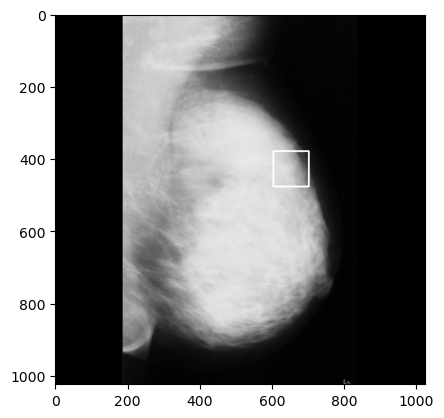

In [17]:
plt.imshow(ROI_box(imgPATH+'mdb240.pgm',
            int(line[19].split(' ')[-3]),
            int(line[19].split(' ')[-2]),
            int(line[19].split(' ')[-1])),
            cmap='gray')

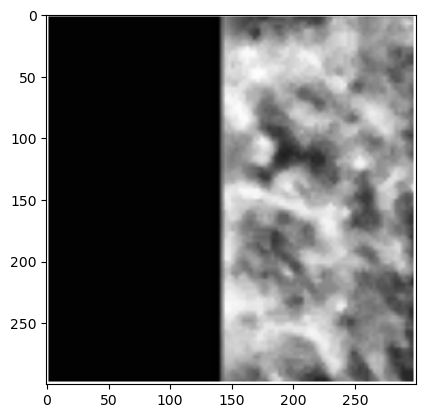

In [139]:
image = ROI_print(imgPATH+'mdb110.pgm',
            int(line[110].split(' ')[-3]),
            int(line[110].split(' ')[-2]),
            int(line[110].split(' ')[-1]),
            20)
ret,thresh = cv2.threshold(image,1,255,0)
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[-1]
# plt.imshow(image,cmap='gray')
x,y,w,h = cv2.boundingRect(cnt)
img = cv2.drawContours(image,[cnt],0,(255,255,255),2)
image = image[y:y+h,x+1:x+w]
image = clahe.apply(image)
image = cv2.resize(image,(300,300))
plt.imshow(img,cmap='gray')

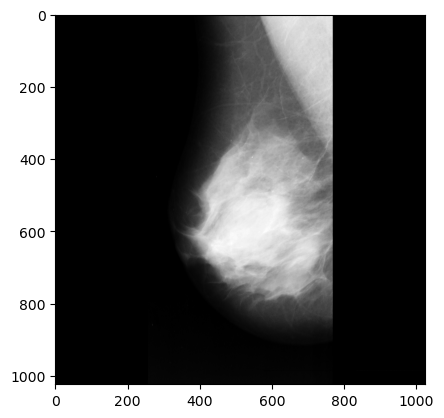

In [43]:
images_tensor = read_pgm(imgPATH+'mdb001.pgm')
plt.imshow(images_tensor, cmap='gray')